# Proyek Klasifikasi Gambar: Animal (cats,dogs,elephants,pandas,zebra)

## Import Semua Packages/Library yang Digunakan

In [1]:
# Standard library
import os
import shutil
import zipfile
import random
from pathlib import Path
from glob import glob

# External library
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Google Colab specific
from google.colab import drive, files

# Downloading utilities
import gdown

# Machine learning libraries
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Scikit-learn
from sklearn.model_selection import train_test_split

# TensorFlow.js
!pip install tensorflowjs
import tensorflowjs as tfjs

#Requirements File Generation
!pip3 freeze > requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 108.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 24.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


## Data Preparation

### Data Loading

In [2]:

zip_url = 'https://drive.google.com/uc?id=10bE32dY4WGUZ4sq02qL_tj8CXgdoJHTc&export=download'
zip_path = './dataset.zip'

dataset_dir = "./dataset"

if os.path.exists(dataset_dir):
    shutil.rmtree(dataset_dir)
os.makedirs(dataset_dir, exist_ok=True)

print("Mengunduh dataset dari Google Drive...")
gdown.download(zip_url, zip_path, quiet=False)

print("Mengekstrak dataset...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("./")

os.remove(zip_path)
print("Dataset telah diekstrak ke:", dataset_dir)

classes = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])
print(f"Class Names: {classes}")


Mengunduh dataset dari Google Drive...


Downloading...
From (original): https://drive.google.com/uc?id=10bE32dY4WGUZ4sq02qL_tj8CXgdoJHTc&export=download
From (redirected): https://drive.google.com/uc?id=10bE32dY4WGUZ4sq02qL_tj8CXgdoJHTc&export=download&confirm=t&uuid=593d012c-40d6-4dd6-80ed-d26535840640
To: /content/dataset.zip
100%|██████████| 3.35G/3.35G [00:52<00:00, 63.4MB/s]


Mengekstrak dataset...
Dataset telah diekstrak ke: ./dataset
Class Names: ['cats', 'dogs', 'elephants', 'pandas', 'zebra']


### Show Plot

Gambar cats memiliki 2530 gambar.
Gambar dogs memiliki 2539 gambar.
Gambar elephants memiliki 2483 gambar.
Gambar pandas memiliki 2460 gambar.
Gambar zebra memiliki 2313 gambar.
Total 12325 gambar.


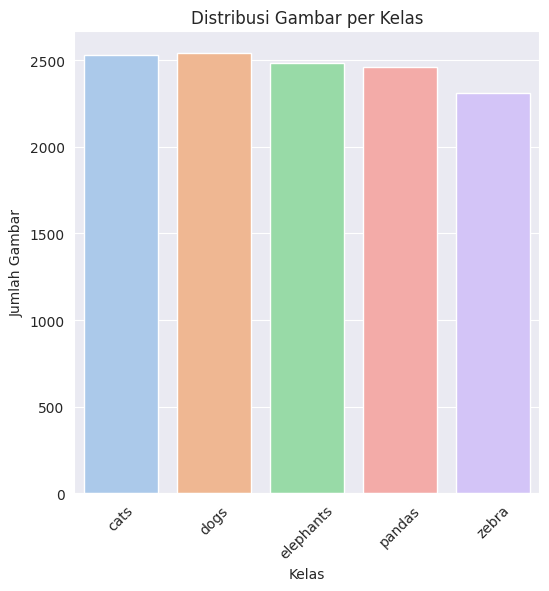

In [3]:
def get_all_images(directory):
    image_extensions = ['.jpg', '.jpeg', '.png']
    images = []
    for root, _, files in os.walk(directory):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                images.append(os.path.join(root, file))
    return images

data = {}
for class_name in classes:
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):
        all_images = get_all_images(class_dir)
        data[class_name] = all_images

labels = []
for class_name, images in data.items():
    labels.extend([class_name] * len(images))
    print(f"Gambar {class_name} memiliki {len(images)} gambar.")

total_images = sum(len(images) for images in data.values())
print(f"Total {total_images} gambar.")

# plot distribusi gambar
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(x=labels, hue=labels, palette="pastel", dodge=False, legend=False)
plot_data.set_title("Distribusi Gambar per Kelas")
plot_data.set_xlabel("Kelas")
plot_data.set_ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.show()

### Data Preprocessing

#### Split Dataset

In [4]:
data_dir = os.path.join('./animals')
os.makedirs(dataset_dir, exist_ok=True)

train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'validation')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for class_name in classes:
    class_dir = os.path.join(dataset_dir, class_name)
    print(f"Memproses direktori: {class_dir}")
    if os.path.isdir(class_dir):
        images = get_all_images(class_dir)

        if len(images) == 0:
            print(f"Direktori {class_name} kosong, dilewati.")
            continue

        # Split dataset menjadi train, validation, dan test
        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
        val_images, test_images = train_test_split(test_images, test_size=0.5, random_state=42)

        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        for img in train_images:
            src_path = img
            dest_path = os.path.join(train_dir, class_name, os.path.basename(img))
            shutil.move(src_path, dest_path)

        for img in val_images:
            src_path = img
            dest_path = os.path.join(val_dir, class_name, os.path.basename(img))
            shutil.move(src_path, dest_path)

        for img in test_images:
            src_path = img
            dest_path = os.path.join(test_dir, class_name, os.path.basename(img))
            shutil.move(src_path, dest_path)

shutil.rmtree(dataset_dir)
print("Pemisahan data selesai.")

Memproses direktori: ./dataset/cats
Memproses direktori: ./dataset/dogs
Memproses direktori: ./dataset/elephants
Memproses direktori: ./dataset/pandas
Memproses direktori: ./dataset/zebra
Pemisahan data selesai.


## Modelling

In [5]:
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(512, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(512, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling2D(),

    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),

    Dense(256, activation='relu'),
    BatchNormalization(),

    Dense(5, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(train_dir)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

class accuracyAchieved(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.95:
            print("\nAkurasi telah mencapai >95%! Menghentikan pelatihan.")
            self.model.stop_training = True

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
    ModelCheckpoint("./model/best_model/best_model.keras",monitor="val_accuracy",save_best_only=True, mode="max",verbose=1),
    accuracyAchieved(),
]

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=55,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks,
)

test_loss, test_acc = model.evaluate(test_generator)

print("Training Accuracy:", history.history['accuracy'][-1])
print("Testing Accuracy:", test_acc)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


./animals/train
Found 9085 images belonging to 5 classes.
Found 1224 images belonging to 5 classes.
Found 1228 images belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/55
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.4248 - loss: 1.4853
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to ./model/best_model/best_model.keras
284/284 ━━━━━━━━━━━━━━━━━━━━ 187s 573ms/step - accuracy: 0.4251 - loss: 1.4844 - val_accuracy: 0.3333 - val_loss: 1.7279 - learning_rate: 0.0010
Epoch 2/55
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.6103 - loss: 0.9566
Epoch 2: val_accuracy improved from 0.33333 to 0.63807, saving model to ./model/best_model/best_model.keras
284/284 ━━━━━━━━━━━━━━━━━━━━ 137s 484ms/step - accuracy: 0.6103 - loss: 0.9565 - val_accuracy: 0.6381 - val_loss: 0.8909 - learning_rate: 0.0010
Epoch 3/55
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.6813 - loss: 0.7841
Epoch 3: val_accuracy improved from 0.63807 to 0.74510, saving model to ./model/best_model/best_model.keras
284/284 ━━━━━━━━━━━━━━━━━━━━ 136s 462ms/step - accuracy: 0.6814 - loss: 0.7841 - val_accuracy: 0.7451 - val_loss: 0.6298 - le

## Evaluasi dan Visualisasi

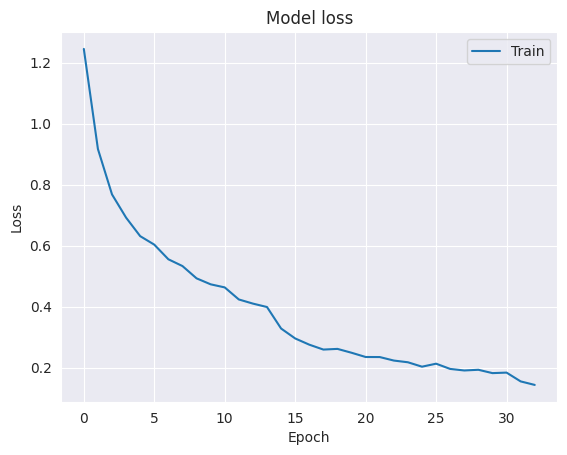

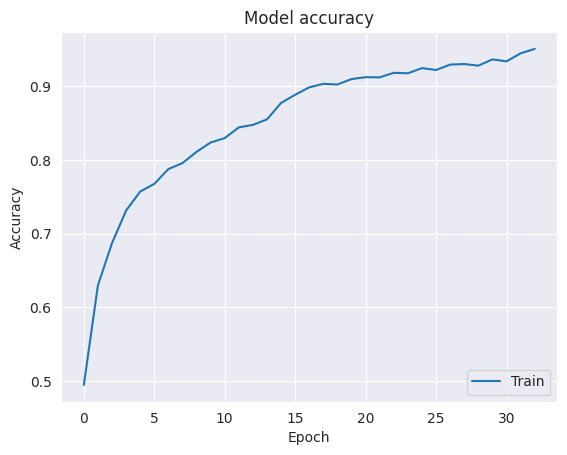

In [6]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()


plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()


## Konversi Model

In [7]:
saved_model = "model/saved_model"
tflite = "model/tflite"
tfj = "model/tfjs_model"

os.makedirs(saved_model, exist_ok=True)
os.makedirs(tflite, exist_ok=True)
os.makedirs(tfj, exist_ok=True)

#SavedModel
tf.saved_model.save(model, saved_model)

# TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open(os.path.join(tflite, "model.tflite"), 'wb') as f:
    f.write(tflite_model)


# TFJS
tfjs.converters.save_keras_model(model, tfj)


Saved artifact at '/tmp/tmporqs5idl'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  132285429024720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132285429026256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132285429026640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132285429026064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132285429024912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132285429025104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132285429025872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132285429027792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132285429028176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132285429026448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13228542902798

failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)

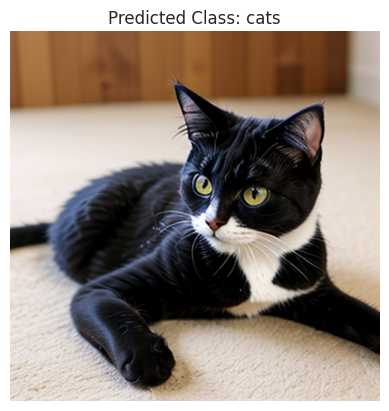

Image: 00144-200124454.png
Probabilities for each class:
cats: 0.4040
dogs: 0.1492
elephants: 0.1489
pandas: 0.1489
zebra: 0.1490




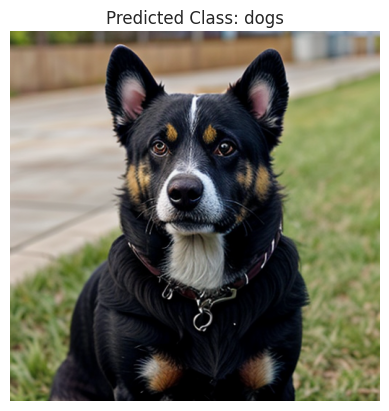

Image: 00715-3846168877.png
Probabilities for each class:
cats: 0.1488
dogs: 0.4046
elephants: 0.1488
pandas: 0.1488
zebra: 0.1488




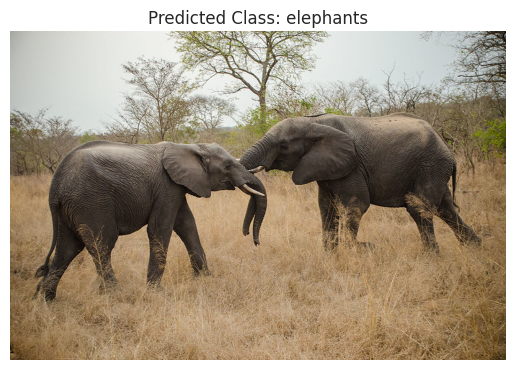

Image: Elephant_160.jpg
Probabilities for each class:
cats: 0.1488
dogs: 0.1488
elephants: 0.4046
pandas: 0.1488
zebra: 0.1488




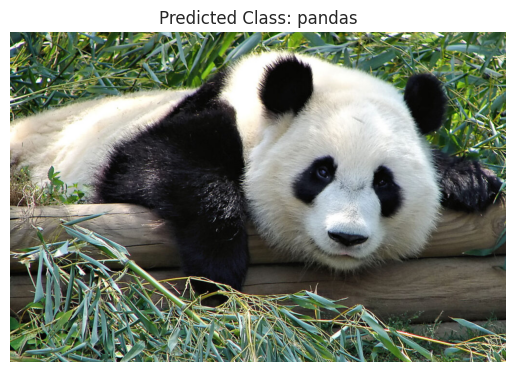

Image: 66c17390-493e-412f-a441-dd9d134917db.jpg
Probabilities for each class:
cats: 0.1489
dogs: 0.1489
elephants: 0.1489
pandas: 0.4045
zebra: 0.1489




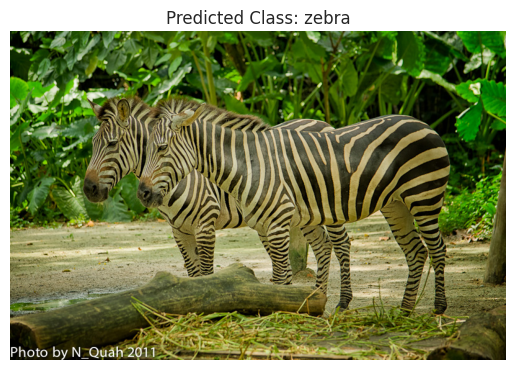

Image: Zebra_103.jpg
Probabilities for each class:
cats: 0.1489
dogs: 0.1489
elephants: 0.1489
pandas: 0.1489
zebra: 0.4045




In [8]:
def preprocess_image(image_path):
    img = Image.open(image_path).resize((150, 150))
    img = img.convert('RGB')
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0).astype(np.float32)
    return img
def predict_image(interpreter, image_path):
    img = preprocess_image(image_path)
    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    probabilities = tf.nn.softmax(output_data).numpy()[0]
    predicted_class_index = np.argmax(probabilities)
    predicted_class = classes[predicted_class_index]
    return predicted_class, probabilities

interpreter = tf.lite.Interpreter(model_path="./model/tflite/model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

image_paths = [
    './animals/test/cats/00144-200124454.png',
    './animals/test/dogs/00715-3846168877.png',
    './animals/test/elephants/Elephant_160.jpg',
    './animals/test/pandas/66c17390-493e-412f-a441-dd9d134917db.jpg',
    './animals/test/zebra/Zebra_103.jpg',
]

for image_path in image_paths:
    predicted_class, probabilities = predict_image(interpreter, image_path)

    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

    print(f"Image: {os.path.basename(image_path)}")
    print("Probabilities for each class:")
    for class_name, prob in zip(classes, probabilities):
        print(f"{class_name}: {prob:.4f}")
    print("\n" + "=" * 50 + "\n")
